In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
from math import ceil
import os

In [2]:
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})
NTURN = [128,256,512,1024,2048]
nTurn = NTURN[0]
betx = 1.9065054393933862
alfx = 1.408226172730429
emitx = 6.066503e-6
nCore_y = 8
nCore_z = 4
n_particles = 1024000
nx = 100
NL_t  = 0.4
NL_c  = 0.01
# NL_nu = 0.3034496449165134
# NL_L  = 1.8
print('singular point = ', NL_c*np.sqrt(betx))
pipe_radius = 0.02*np.sqrt(2.0)
#pipe_radius = 0.013
#pipe_radius = 0.01

singular point =  0.013807626296338507


In [3]:
# H1 = 0.04005207 

# 1. Preparation

In [4]:
beam, lattice = impact.readInputFile('test_IOTA.in')

reading ImpactZ input file (test_IOTA.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [5]:
beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
beam.distribution.emitx = emitx
beam.n_particles = n_particles

ke   = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

In [6]:
### 1.2. generate particles

In [7]:
##### 1.2.1. generate pData

In [8]:
beamtmp = copy(beam)
beamtmp.distribution.distribution_type = 'IOTA_Waterbag'
beamtmp.distribution.NL_t = NL_t
beamtmp.distribution.NL_c = NL_c
beamtmp.distribution.betx = betx
beamtmp.distribution.bety = betx
beamtmp.distribution.alfx = alfx
beamtmp.distribution.alfy = alfx
beamtmp.distribution.emitx = emitx
beamtmp.distribution.emity = emitx
beamtmp.distribution.betz = 0.0
beamtmp.distribution.alfz = 0.0
beamtmp.distribution.emitz = 0.0
beamtmp.distribution.mode = 'twiss'

loop = impact.getElem('loop')
loop.turns = 1

write_pData = impact.getElem('write_raw_ptcl')
write_pData.turn = 1
write_pData.file_id = 111110
write_pData.format_id = 2

impact.writeInputFile(beamtmp,[loop,write_pData]);
impact.run(beamtmp)

0

In [9]:
##### 1.2.2. reOrder pData s.t. y>0 comes first

In [10]:
from copy import deepcopy as copy
pDataTmp = impact.readParticleData(111110,ke,mass,freq,format_id=2)
pData = copy(pDataTmp)
iTmp = np.argwhere(pData[:,2]>=0)[:,0]
jTmp = np.argwhere(pData[:,2] <0)[:,0]
pData[:len(iTmp),:] = pDataTmp[iTmp,:]
pData[len(iTmp):,:] = pDataTmp[jTmp,:]
pData[:,-1] = np.arange(1,len(pData)+1)
npt_yup = len(iTmp)
print('npt_yup=',npt_yup)

npt_yup= 512174


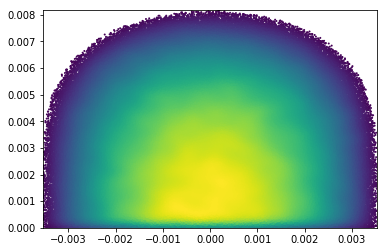

In [14]:
impact.plot.density(pData[:len(iTmp),0],pData[:len(iTmp),2])

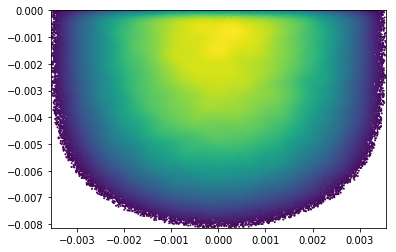

In [15]:
impact.plot.density(pData[len(iTmp):,0],pData[len(iTmp):,2])

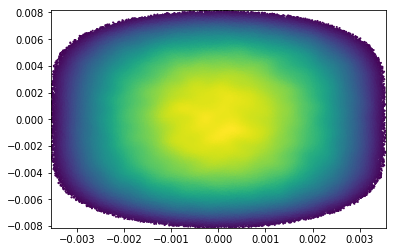

In [16]:
impact.plot.density(pData[:,0],pData[:,2])

In [ ]:
##### 1.2.3. generate testP

In [ ]:
testP = 0.0
k=0
q_m = beamtmp.multi_charge.q_m[0]
pTest = []
nx = 100
xmax = 0.98
for x in np.linspace(-xmax,xmax,nx):
    for y in np.linspace(-xmax,xmax,nx):
        if x**2+y**2<=xmax**2 and y>0:
            k+=1
            pTest.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k]) 
pTest = np.array(pTest)
nptTest = len(pTest)
print('nptTest=',nptTest)

In [ ]:
def normalize(data):
    data[:,1] = (data[:,0]*alfx/np.sqrt(betx) + data[:,1]*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx/np.sqrt(betx) + data[:,3]*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    
def unnormalize(data):
    data[:,1] = (-data[:,0]*alfx + data[:,1])*NL_c/np.sqrt(betx)
    data[:,3] = (-data[:,2]*alfx + data[:,3])*NL_c/np.sqrt(betx)
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c

In [ ]:
unnormalize(pTest)

In [ ]:
##### 1.2.4. combine pData, pTest  and Check

In [ ]:
pData[:,8] = pData[:,8] + nptTest
if nptTest>0:
    pData = np.concatenate((pTest,pData),axis=0)
print(pData.shape)
impact.writeParticleData(pData, ke, mass, freq)

In [ ]:
beam.n_particles = n_particles + nptTest
beam.distribution.distribution_type = 'ReadFile'
impact.writeInputFile(beam,[loop,write_pData]);
impact.run(beam)

In [ ]:
pDataInit = impact.readParticleData(111110,ke,mass,freq,format_id=2)
plt.figure(figsize=[11,3])
plt.subplot(1,3,1)
plt.scatter(pDataInit[nptTest:,0],pDataInit[nptTest:,2],s=0.1);
plt.subplot(1,3,2)
plt.scatter(pDataInit[:nptTest,0],pDataInit[:nptTest,2],s=0.1);
plt.subplot(1,3,3)
plt.scatter(pDataInit[:,0],pDataInit[:,2],s=0.1);
plt.tight_layout()

In [ ]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.hist(pDataInit[:,0],bins=40);
plt.subplot(1,2,2)
plt.hist(pDataInit[:,2],bins=40);

### 1.3 adjust lattice

In [ ]:
# L=0.0
# for i in range(len(lattice)):
#     if 'length' in lattice[i].keys():
#         L = L+lattice[i].length
# print(L)

# for i in range(len(lattice)):
#     if 'length' in lattice[i].keys():
#         lattice[i].n_sckick = ceil(lattice[i].length*20)
#         if lattice[i].type in ['nonlinear_insert','dipole']:
#             lattice[i].n_map = 10
#         else:
#             lattice[i].n_map = 2
        
lattice = [ item for item in lattice if not item.type == 'write_raw_ptcl' ]
lattice = [ item for item in lattice if not item.type == '-8' ]
lattice = [ item for item in lattice if not item.type == 'multipole_thin' ]

L=0.0
for i in range(len(lattice)):
    if 'length' in lattice[i].keys():
        L = L+lattice[i].length
print(L)

# 2. Run

In [ ]:
print('===========================')
print('=========== Run ===========')
print('===========================')

In [ ]:
TBTsplit = impact.getElem('TBT_multiple_file')
TBTsplit.file_id = nTurn+1
TBTsplit.pID_begin = nptTest+1
TBTsplit.pID_end   = nptTest+npt_yup
TBTsplit.n_files   = 32

lattice.insert(1,TBTsplit)

TBT = impact.getElem('TBT')
TBT.pID_begin = 1
TBT.pID_end   = nptTest
TBT.file_id = nTurn
lattice.insert(1,TBT)

if nTurn == 128:
    lattice[0].turns = nTurn
else:
    lattice[0].turns = int(nTurn/2)

for i in range(len(lattice)):
    if 'pipe_radius' in lattice[i].keys() and lattice[i].type!='dipole':
        lattice[i].pipe_radius = pipe_radius
        
lattice.append(impact.getElem('write_raw_ptcl'))
if nTurn == 128:
    lattice[-1].turn = nTurn
else:
    lattice[-1].turn = int(nTurn/2)

lattice[-1].file_id = nTurn
lattice[-1].format_id = 2

In [ ]:
beam.n_particles = len(pDataInit)
beam.distribution.distribution_type = 'ReadFile_binary'
if nTurn == 128:
    beam.distribution.file_id = 111110
else:
    beam.distribution.file_id = int(nTurn/2)
beam.nCore_y = 64
beam.nCore_z = 48
impact.writeInputFile(beam,lattice,'test.in.'+str(nTurn)+'.forward') 
#impact.run(beam)

indexTBT,TBTdataTmp = impact.readTBT(errIndex,ke,mass,freq)
indexTBT,TBTdataTmp_Inv = impact.readTBT_integral(errIndex)
TBTdataTmp_Inv[:,1,:]=TBTdataTmp_Inv[:,1,:]**2
pDataOut= impact.readParticleData(-111111,ke,mass,freq)
pDataIn = impact.readParticleData(-111110,ke,mass,freq)

print('pDataIn.shape',pDataIn.shape)
print('pDataOut.shape',pDataOut.shape)
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.scatter(pDataIn[:,0],pDataIn[:,2],s=0.1)
plt.xlim(-0.012,0.012)
plt.ylim(-0.012,0.012)
plt.subplot(1,3,2)
plt.scatter(pDataOut[:,0],pDataOut[:,2],s=0.1)
plt.xlim(-0.012,0.012)
plt.ylim(-0.012,0.012)
plt.subplot(1,3,3)
plt.scatter(pDataOut[:,0],pDataOut[:,2],s=0.1)
plt.tight_layout()
plt.savefig('pData.InOut.png',dpi=180,bbox_inches = "tight")

print(TBTdataTmp.shape)
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.scatter(TBTdataTmp[0,0,:],TBTdataTmp[0,2,:],s=0.1)
plt.xlim(-0.012,0.012)
plt.ylim(-0.012,0.012)
plt.subplot(1,3,2)
plt.scatter(TBTdataTmp[-1,0,:],TBTdataTmp[-1,2,:],s=0.1)
plt.xlim(-0.012,0.012)
plt.ylim(-0.012,0.012)
plt.subplot(1,3,3)
plt.scatter(TBTdataTmp[-1,0,:],TBTdataTmp[-1,2,:],s=0.1)
plt.tight_layout()
plt.savefig('TBTdata.InOut.png',dpi=180,bbox_inches = "tight")